### Importing the Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter

import cv2
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

### Dataset Path

In [2]:
satelliteDatasetPath = "C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Machine Learning/Satellite Image Classification"

In [3]:
satelliteImgHeight = 128
satelliteImgWidth = 128

In [4]:
satelliteTrainingData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                 subset = "training",
                                                                 seed = 42,
                                                                 image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                 label_mode = "categorical",
                                                                 validation_split = 0.20, 
                                                                 batch_size = 64
                                                                )

satelliteValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  )

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


### Data Augmentation

In [5]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

satelliteTrainAugmented = satelliteTrainingData.map(lambda i, j: (dataAugmentation(i), j))
# satelliteTrainAugmented

### Normalization

In [6]:
satelliteNormalizationLayer = tf.keras.layers.Rescaling(1./255)

satelliteTrainNorm = satelliteTrainAugmented.map(lambda i, j: (satelliteNormalizationLayer(i), j))
satelliteValidationNorm = satelliteValidationData.map(lambda i, j: (satelliteNormalizationLayer(i), j))

In [7]:
classNames = satelliteTrainingData.class_names
classNames

['cloudy', 'desert', 'green_area', 'water']

In [8]:
labels = []
for _, label in satelliteTrainNorm:
    # Convert one-hot to class index
    labels.extend(np.argmax(label.numpy(), axis = 1))

# Count Occurrences of each class
labelCounts = Counter(labels)
# print(labelCounts)

# Print class-wise count
for ind, count in labelCounts.items():
    print(f"{classNames[ind]}: {count}")

water: 1183
cloudy: 1233
green_area: 1182
desert: 907


### Prefetch and Shuffle

In [9]:
autotune = tf.data.AUTOTUNE

satelliteTrainPrefetch = satelliteTrainNorm.prefetch(buffer_size = autotune).shuffle(buffer_size = 64)
satelliteValidationPrefetch = satelliteValidationNorm.prefetch(buffer_size = autotune)

### Compute Class Weights

In [10]:
classWeights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(labels),
    y = labels
)

classWeightDict = {i : classWeights[i] for i in range(len(classWeights))}
print(f"Computed Class Weights: {classWeightDict}")

Computed Class Weights: {0: 0.9134225466342255, 1: 1.2417309812568909, 2: 0.952834179357022, 3: 0.952028740490279}


### Building a CNN Model

In [14]:
cnnModel = keras.Sequential([
    keras.layers.Input(shape = (satelliteImgHeight, satelliteImgWidth, 3)),
    keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),
    
    keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),
    
    keras.layers.Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),
    
    keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),
    
    keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),
    
    keras.layers.Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "same"),
    keras.layers.MaxPool2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation = "softmax")
])

In [15]:
cnnModel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

### Train the Model

In [16]:
modelHistory = cnnModel.fit(
    satelliteTrainPrefetch, 
    validation_data = satelliteValidationPrefetch,
    epochs = 20,
    class_weight = classWeightDict
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 917s 10s/step - accuracy: 0.5256 - loss: 0.8927 - val_accuracy: 0.7211 - val_loss: 0.4044
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.7325 - loss: 0.3850 - val_accuracy: 0.7282 - val_loss: 0.4928
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - accuracy: 0.7363 - loss: 0.3785 - val_accuracy: 0.7087 - val_loss: 0.3801
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.7566 - loss: 0.3518 - val_accuracy: 0.7211 - val_loss: 0.3904
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.7716 - loss: 0.3399 - val_accuracy: 0.8020 - val_loss: 0.3584
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7825 - loss: 0.3457 - val_accuracy: 0.6838 - val_loss: 0.3913
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7358 - loss: 0.3538 - val_accuracy: 0.7282 - val_loss: 0.3895
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7551 - loss: 0.3526 - val_accuracy: 0.8144 - 

### Model Summary

In [41]:
cnnModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,032,014 (3.94 MB)

 Trainable params: 344,004 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 688,010 (2.62 MB)

In [42]:
lossScore, accuracyScore = cnnModel.evaluate(satelliteValidationData)
print(f"Validation Accuracy: {accuracyScore:.2%}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.6963 - loss: 167.3622
Validation Accuracy: 70.07%


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
[[267   0   0   0]
 [  0 224   0   0]
 [  0   0   0 318]
 [  0  19   0 298]]


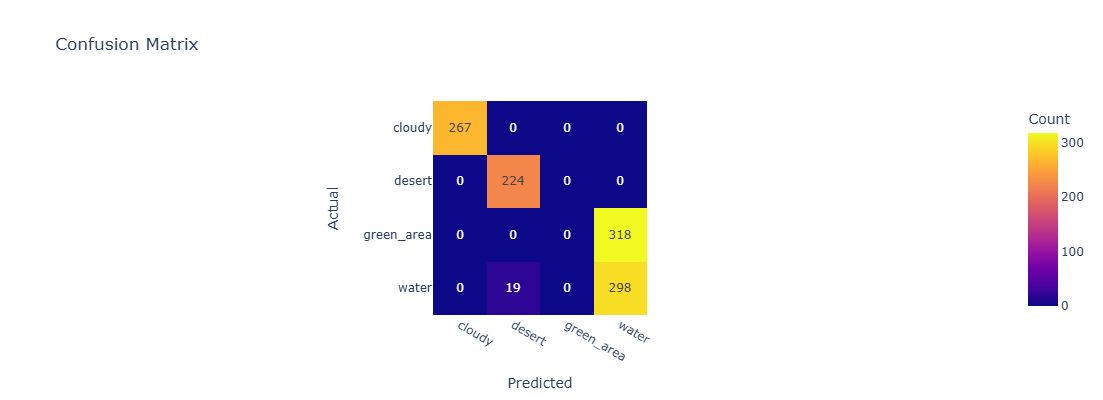

In [43]:
trueLabels = []
predictedLabels = []

for images, labels in satelliteValidationData:
    pred = cnnModel.predict(images)
    predictedLabels.extend(np.argmax(pred, axis = 1))
    trueLabels.extend(np.argmax(labels.numpy(), axis = 1))

confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
print(confusionMatrix)

fig = px.imshow(confusionMatrix, 
                labels = dict(x = "Predicted", y = "Actual", color = "Count"), 
                x = satelliteTrainingData.class_names, 
                y = satelliteTrainingData.class_names,
                text_auto = True, 
                title = "Confusion Matrix"
               )
fig.update_layout(width = 500, height = 400)

### Plot the Accuracy and Loss

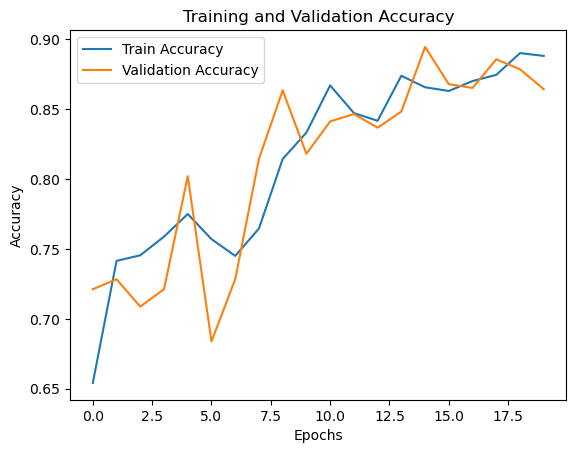

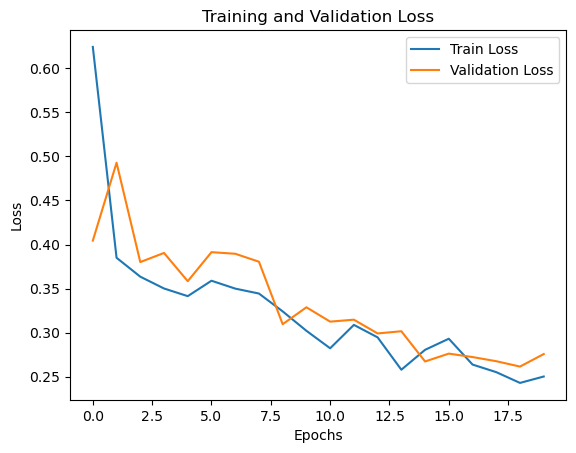

In [44]:
# Accuracy
plt.plot(modelHistory.history['accuracy'], label = "Train Accuracy")
plt.plot(modelHistory.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


# Loss
plt.plot(modelHistory.history["loss"], label = "Train Loss")
plt.plot(modelHistory.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

### New Prediction

In [45]:
from PIL import Image

In [76]:
# img = Image.open("C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Machine Learning/Satellite Image Classification/cloudy/train_799.jpg")
# img = Image.open("C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Machine Learning/Satellite Image Classification/desert/desert(37).jpg")
img = Image.open("C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Machine Learning/Satellite Image Classification/green_area/Forest_50.jpg")
# img = Image.open("C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Machine Learning/Satellite Image Classification/water/SeaLake_117.jpg")
# img = Image.open("C:/Users/Logiya Vidhyapathy/Documents/KGISL Data Science/Cloud.jpg")

In [77]:
print(img.mode)

if img.mode == "CMYK":
    img = img.convert("RGB")

print(img.mode)

img = img.resize((128, 128))

img_array = np.array(img) / 255.0
print(img_array.shape)

img_array = np.expand_dims(img_array, axis = 0)
print(img_array.shape)

RGB
RGB
(128, 128, 3)
(1, 128, 128, 3)


In [78]:
prediction = cnnModel.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [79]:
predictedClass = np.argmax(prediction)
predictedClass

3

In [80]:
classLabels = satelliteTrainingData.class_names
classLabels

['cloudy', 'desert', 'green_area', 'water']

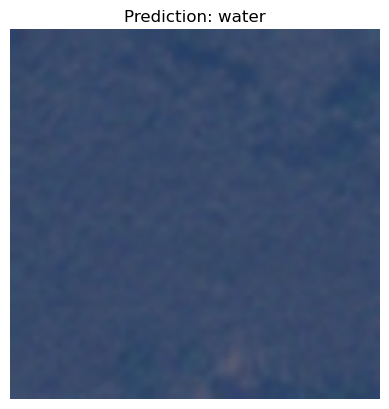

In [81]:
plt.imshow(img)
plt.title(f"Prediction: {classLabels[predictedClass]}")
plt.axis("off")
plt.show()